In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

### Loading the Dataset

In [13]:
def load_images(path):
    with open(path, 'rb') as f:
        # Read the first 16 bytes which contain metadata
        magic, num, rows, cols = np.frombuffer(f.read(16), dtype=np.dtype('>i4'), count=4)
        # Read the remaining bytes which contain the image data
        images = np.frombuffer(f.read(), dtype=np.dtype('>u1')).reshape(num, rows, cols)
    return images

def load_labels(path):
    with open(path, 'rb') as f:
        # Read the first 8 bytes which contain metadata
        magic, num = np.frombuffer(f.read(8), dtype=np.dtype('>i4'), count=2)
        # Read the remaining bytes which contain the label data
        labels = np.frombuffer(f.read(), dtype=np.dtype('>u1'))
    return labels

# Paths to the downloaded files
train_images_path = 'train-images.idx3-ubyte'
train_labels_path = 'train-labels.idx1-ubyte'
test_images_path = 't10k-images.idx3-ubyte'
test_labels_path = 't10k-labels.idx1-ubyte'

# Load the datasets
train_images = load_images(train_images_path)
train_labels = load_labels(train_labels_path)
test_images = load_images(test_images_path)
test_labels = load_labels(test_labels_path)

# Checking if the data is loaded correctly
print(f'Training images shape: {train_images.shape}')
print(f'Training labels shape: {train_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')


Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


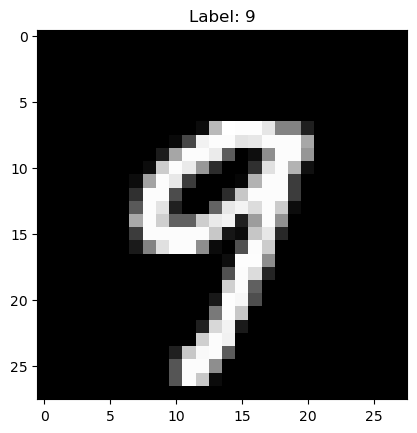

In [14]:
def convert_to_dataframe(images, labels):
    # Flatten the images array from (num_samples, 28, 28) to (num_samples, 784)
    flattened_images = images.reshape(images.shape[0], -1)
    # Create a DataFrame with the flattened images
    df = pd.DataFrame(flattened_images)
    # Add the labels as a new column
    df['label'] = labels
    return df

# Convert training and test sets to DataFrames
train_df = convert_to_dataframe(train_images, train_labels)
test_df = convert_to_dataframe(test_images, test_labels)

def plot_image(image, label):
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(f'Label: {label}')
    plt.show()

# Plot the first image in the training set
plot_image(train_images[45], train_labels[45])


In [15]:
# Display the first few rows of the training DataFrame
print(train_df.head())

   0  1  2  3  4  5  6  7  8  9  ...  775  776  777  778  779  780  781  782  \
0  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
1  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
2  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
3  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
4  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   

   783  label  
0    0      5  
1    0      0  
2    0      4  
3    0      1  
4    0      9  

[5 rows x 785 columns]


### Preprocessing the Dataset

In [16]:
#Transposed and turned the dataset into a 2D one
train_images = train_images.reshape(train_images.shape[0], -1).T / 255.0
test_images = test_images.reshape(test_images.shape[0], -1).T / 255.0
train_labels = train_labels.T
test_labels = test_labels.T

### Initializing Parameters

In [17]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

### Activation Functions

In [18]:
def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A

### Forward Propagation

In [19]:
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

### Derivative of ReLU

In [20]:
def ReLU_deriv(Z):
    return Z > 0

### One-Hot Encoding (Labels)

In [21]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

### Bakwards Propagation

In [22]:
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y, m):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

### Updating Parameters (Gradient Descent)

In [23]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 -= alpha * dW1
    b1 -= alpha * db1    
    W2 -= alpha * dW2  
    b2 -= alpha * db2    
    return W1, b1, W2, b2

### Making Predictions

In [24]:
def get_predictions(A2):
    return np.argmax(A2, 0)

### Calculating Accuracy

In [25]:
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

### Training the Network

In [26]:
def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    m = X.shape[1]
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y, m)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            predictions = get_predictions(A2)
            accuracy = get_accuracy(predictions, Y)
            print(f"Iteration: {i}, Accuracy: {accuracy}")
    return W1, b1, W2, b2

W1, b1, W2, b2 = gradient_descent(train_images, train_labels, 0.10, 500)

Iteration: 0, Accuracy: 0.08076666666666667
Iteration: 10, Accuracy: 0.106
Iteration: 20, Accuracy: 0.16788333333333333
Iteration: 30, Accuracy: 0.2504
Iteration: 40, Accuracy: 0.3338833333333333
Iteration: 50, Accuracy: 0.3984
Iteration: 60, Accuracy: 0.4474
Iteration: 70, Accuracy: 0.4868
Iteration: 80, Accuracy: 0.5200833333333333
Iteration: 90, Accuracy: 0.5521833333333334
Iteration: 100, Accuracy: 0.5803666666666667
Iteration: 110, Accuracy: 0.6032666666666666
Iteration: 120, Accuracy: 0.6237333333333334
Iteration: 130, Accuracy: 0.6419833333333334
Iteration: 140, Accuracy: 0.65815
Iteration: 150, Accuracy: 0.6715833333333333
Iteration: 160, Accuracy: 0.6844166666666667
Iteration: 170, Accuracy: 0.6957666666666666
Iteration: 180, Accuracy: 0.7052833333333334
Iteration: 190, Accuracy: 0.7148
Iteration: 200, Accuracy: 0.7227
Iteration: 210, Accuracy: 0.7302
Iteration: 220, Accuracy: 0.7371166666666666
Iteration: 230, Accuracy: 0.74395
Iteration: 240, Accuracy: 0.7503
Iteration: 250,

### Testing the Model

Prediction:  [5]
Label:  5


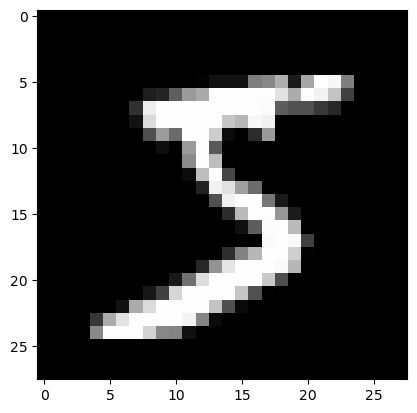

Prediction:  [0]
Label:  0


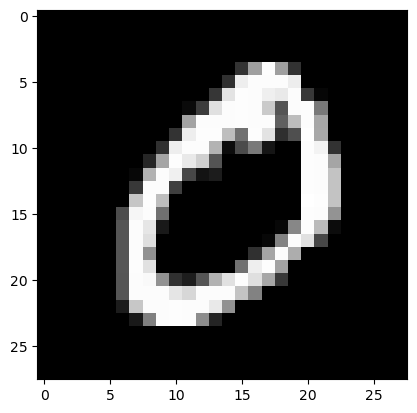

Prediction:  [9]
Label:  4


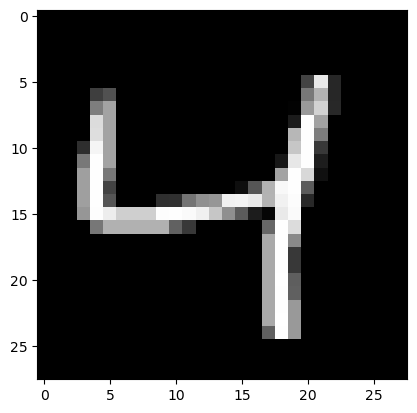

Prediction:  [1]
Label:  1


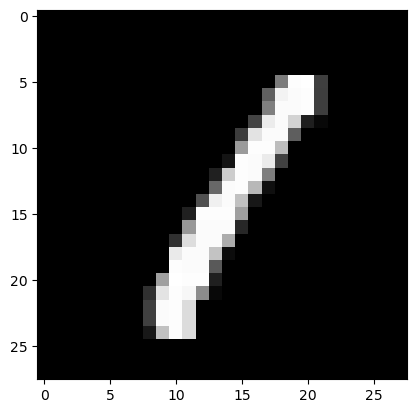

Test Accuracy: 0.8406


In [27]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = train_images[:, index, None]
    prediction = make_predictions(train_images[:, index, None], W1, b1, W2, b2)
    label = train_labels[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()
    
# Test predictions on the first few images
for i in range(4):
    test_prediction(i, W1, b1, W2, b2)

# Evaluate the accuracy on the test set
test_predictions = make_predictions(test_images, W1, b1, W2, b2)
test_accuracy = get_accuracy(test_predictions, test_labels)
print(f"Test Accuracy: {test_accuracy}")